In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error
%matplotlib inline 

In [3]:
from mll_calc.all_jobs import uncs, job_dirs

### hi hello

In [4]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
mll_gam = rdrive + 'mll/gam_spec/'
mll_nuc = rdrive + 'mll/nuc_conc/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'

In [9]:
# uncertainty for both MLL and Scikit are now sqrt(counts), but implemented differently (std dev versus rand err method in scikit)
# nuc and act trainsets still use flat 5% unc/rand err
# now have scikit results using 6.7% trainset (computationally cheap to also track 100%)

### MLL Results

In [6]:
job_act = 'Job0_unc0.05'
job = job_act#'Job1_unc0.0'

# nuc_conc
n29mll = pd.read_csv(mll_nuc + 'train/' + job_act + '/' + job_act + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# acts
a32mll = pd.read_csv(mll_gam + 'act32/' + job_act + '/' + job_act + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#a9mll = pd.read_csv(mll_gam + 'act9/' + job_act + '/' + job_act + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
a4mll = pd.read_csv(mll_gam + 'act4/' + job_act + '/' + job_act + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# n113
d1mll113 = pd.read_csv(mll_gam + 'd1_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d2mll113 = pd.read_csv(mll_gam + 'd2_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll113 = [n29mll, a32mll, d1mll113, d2mll113] #a9mll, # order is important (d6, d5, d4)

# n31
d1mll31 = pd.read_csv(mll_gam + 'd1_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d2mll31 = pd.read_csv(mll_gam + 'd2_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d3mll31 = pd.read_csv(mll_gam + 'd3_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d4mll31 = pd.read_csv(mll_gam + 'd4_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d5mll31 = pd.read_csv(mll_gam + 'd5_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d6mll31 = pd.read_csv(mll_gam + 'd6_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll31 = [n29mll, a32mll, a4mll, d1mll31, d2mll31, d3mll31, d6mll31, d5mll31, d4mll31] # order is important (d6, d5, d4)

In [58]:
#mll113 = [n29mll, a32mll, a32mll, d1mll113, d2mll113] #a9mll,

In [40]:
det = ['nuc29', 'act32', 'act4/9', 'd1', 'd2', 'd3', 'd6', 'd5', 'd4'] 
detdesc = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
csv_end = '_scores.csv'
# for dataframes
algcol = ['knn31', 'dtree31', 'mll31', 'knn113', 'dtree113', 'mll113']#, 'pca_knn', 'pca_dtree']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']
# tset fracs for scikit results
tfrac007 = '_tset0.067_'
tfrac100 = '_tset1.0_'
tfrac = tfrac007

## Pull all results together into dataframe
### Scikit results are grabbed "live" for results dataframes

16 May 2021 results plotted have the sqrt(counts) errors implemented for scikit, but mll results are not yet in, so all MLL results show the flat 5% unc results instead

In [59]:
results = {}
for i, p in enumerate(pred):
    if p == 'reactor':
        levels = [algcol, scrcol]
    else: 
        levels = [algcol, errcol]
    df = pd.DataFrame(index=det, columns=pd.MultiIndex.from_product(levels, names=["Algorithm", "Metric"]))
    for j, d in enumerate(det):
        ######################
        ### Scikit Results ###
        ######################
        learn_path = learn_gam
        knncsv = p + '_knn' + tfrac + detdesc[j] + csv_end
        dtrcsv = p + '_dtree' + tfrac + detdesc[j] + csv_end
        if 'nuc' in d or 'act' in d:
            # scikit for 113 and 31 lists will both have knn nuc29 & act32 as their starting points
            # then act4, act9 get applied to n31, n113 respectively 
            if d == 'act4/9':
                knncsv = p + '_knn' + tfrac + 'act4' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act4' + csv_end
                knn31 = pd.read_csv(learn_path + 'act4/' + knncsv).drop(columns='Unnamed: 0')
                dtr31 = pd.read_csv(learn_path + 'act4/' + dtrcsv).drop(columns='Unnamed: 0')
                knncsv = p + '_knn' + tfrac + 'act9' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act9' + csv_end
                knn113 = pd.read_csv(learn_path + 'act9/' + knncsv).drop(columns='Unnamed: 0')
                dtr113 = pd.read_csv(learn_path + 'act9/' + dtrcsv).drop(columns='Unnamed: 0')
            else:
                if 'nuc' in d:
                    learn_path = learn_nuc
                knn31 = knn113 = pd.read_csv(learn_path + d + '/' + knncsv).drop(columns='Unnamed: 0')
                dtr31 = dtr113 = pd.read_csv(learn_path + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        else:
            knn31 = pd.read_csv(learn_path + d + '_n31/' + knncsv).drop(columns='Unnamed: 0')
            dtr31 = pd.read_csv(learn_path + d + '_n31/' + dtrcsv).drop(columns='Unnamed: 0')
            knn113 = pd.read_csv(learn_path + d + '_n113/' + knncsv).drop(columns='Unnamed: 0')
            dtr113 = pd.read_csv(learn_path + d + '_n113/' + dtrcsv).drop(columns='Unnamed: 0')
        #################################
        ### MLL Results + Error Calcs ###
        #################################
        if p == 'reactor':
            metric = 'test_score'
            dfmetric = 'Accuracy'
            dfstd = 'Acc Std'
            if j <= 4:
                df.loc[d, ('mll113', dfmetric)] = accuracy_score(mll113[j][predmll[i]], mll113[j]['pred_' + predmll[i]])
                df.loc[d, ('mll113', dfstd)] = np.std(mll113[j][predmll[i] + '_Score'])
            df.loc[d, ('mll31', dfmetric)] = accuracy_score(mll31[j][predmll[i]], mll31[j]['pred_' + predmll[i]])
            df.loc[d, ('mll31', dfstd)] = np.std(mll31[j][predmll[i] + '_Score'])
        else:
            metric = 'test_neg_mean_absolute_error'
            dfmetric = 'Neg MAE'
            dfstd = 'MAE Std'
            if j <= 4:
                df.loc[d, ('mll113', dfmetric)] = -mean_absolute_error(mll113[j][predmll[i]], mll113[j]['pred_' + predmll[i]])
                df.loc[d, ('mll113', dfstd)] = np.std(mll113[j][predmll[i] + '_Error'])
            df.loc[d, ('mll31', dfmetric)] = -mean_absolute_error(mll31[j][predmll[i]], mll31[j]['pred_' + predmll[i]])
            df.loc[d, ('mll31', dfstd)] = np.std(mll31[j][predmll[i] + '_Error'])
        df.loc[d, ('knn113', dfmetric)] = knn113[metric].mean()
        df.loc[d, ('knn113', dfstd)] = knn113[metric].std()
        df.loc[d, ('dtree113', dfmetric)] = dtr113[metric].mean()
        df.loc[d, ('dtree113', dfstd)] = dtr113[metric].std()    
        df.loc[d, ('knn31', dfmetric)] = knn31[metric].mean()
        df.loc[d, ('knn31', dfstd)] = knn31[metric].std()
        df.loc[d, ('dtree31', dfmetric)] = dtr31[metric].mean()
        df.loc[d, ('dtree31', dfstd)] = dtr31[metric].std()
        #pcaknn = pd.read_csv(learn_path + 'pca_' + d + '/' + knncsv).drop(columns='Unnamed: 0')
        #pcadtr = pd.read_csv(learn_path + 'pca_' + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        #df.loc[d, ('pca_knn', dfmetric)] = pcaknn[metric].mean()
        #df.loc[d, ('pca_knn', dfstd)] = pcaknn[metric].std()
        #df.loc[d, ('pca_dtree', dfmetric)] = pcadtr[metric].mean()
        #df.loc[d, ('pca_dtree', dfstd)] = pcadtr[metric].std()
    results[p] = df

In [60]:
results['cooling']

Algorithm    knn31           dtree31              mll31            knn113  \
Metric     Neg MAE  MAE Std  Neg MAE   MAE Std  Neg MAE  MAE Std  Neg MAE   
nuc29     -397.403  7.06264 -97.5448   2.26976 -37.2127  49.8142 -397.403   
act32     -120.916  2.10136 -104.049   2.12209   -43.51  48.9552 -120.916   
act4/9    -184.906  1.45179  -154.77   2.49274   -35.34  53.2337 -138.193   
d1        -161.609  2.64811 -151.312    4.3442 -64.5305  103.662 -171.044   
d2        -166.675  3.16378 -168.725  0.816111 -78.8378  123.411 -181.392   
d3        -179.199  3.01108 -185.139   3.70138  -95.837  140.845 -180.898   
d6        -170.764  1.52038 -176.012   1.83759  -91.884  136.427 -172.717   
d5        -170.448  0.42432 -179.581   1.11811 -97.1139  141.276 -175.606   
d4          -181.4  0.76631 -189.906   2.30397 -103.583  146.859 -182.458   

Algorithm          dtree113            mll113           
Metric     MAE Std  Neg MAE  MAE Std  Neg MAE  MAE Std  
nuc29      7.06264 -97.5448  2.26976 -37.2127  49.8142  
act32      2.10136 -104.049  2.12209   -43.51  48.9552  
act4/9     1.04496 -133.747  1.79103   -43.51  48.9552  
d1         1.29628 -148.551  2.02376 -65.7742  106.817  
d2          2.5369 -167.321  2.09496  -78.393  123.729  
d3         1.87018 -184.432  3.18185      NaN      NaN  
d6         2.15177 -177.343  2.12654      NaN      NaN  
d5         2.17351 -177.679  1.10744      NaN      NaN  
d4         2.97669 -190.627  1.42949      NaN      NaN

# Plotting

In [34]:
# color dict (use: colors['XColor'])
colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

In [116]:
def plot_curves(pred_param, title):
    plt.clf()
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        ax.set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        ax.set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    plotdf = results[pred_param]#.iloc[1:]
    # bad form alert! order of all below lists impt: 
    x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI'] # check that these match with df.index!
    c = ['MBrwn', 'MTeal', 'MPurp', 'DBrwn', 'DTeal', 'DPurp']#, 'LBrwn', 'LTeal']
    lbl = ['kNN 31', 'Dec Tree 31', 'MLL Calc 31', 'kNN 113', 'Dec Tree 113', 'MLL Calc 113']#, 'PCA kNN', 'PCA Dec Tree']
    for i, alg in enumerate(algcol):
        y = np.array(plotdf[alg][metric], dtype=float)
        sd = np.array(plotdf[alg][std], dtype=float)
        ax.plot(x, y, 'o-', color=colors[c[i]], mew=0, ms=5, label=lbl[i])
        ax.fill_between(x, y - sd, y + sd, color=colors[c[i]], alpha=0.2) #interpolate=True, 
    
    ax.tick_params(labelsize=12)
    h,l = ax.get_legend_handles_labels()
    handles = [h[5], h[2], h[3], h[0], h[4], h[1]]#, h[6], h[7]]
    labels = [l[5], l[2], l[3], l[0], l[4], l[1]]#, l[6], l[7]]
    ax.legend(handles,labels,loc='best')
    
    if pred_param == 'reactor':
        ax.set_ylim(None, top=1.08)
    elif pred_param == 'burnup':
        ax.set_ylim(None, top=70)
    elif pred_param == 'enrichment':
        ax.set_ylim(None, top=0.1)
    else:
        ax.set_ylim(-250, top=30)
    plt.show()
    
    #sv_fig = './plots/detector_preds_' + pred_param + '.png'
    #fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

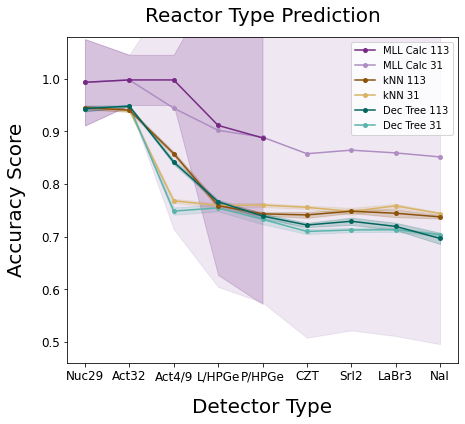

In [111]:
plot_curves('reactor', 'Reactor Type Prediction')

<Figure size 432x288 with 0 Axes>

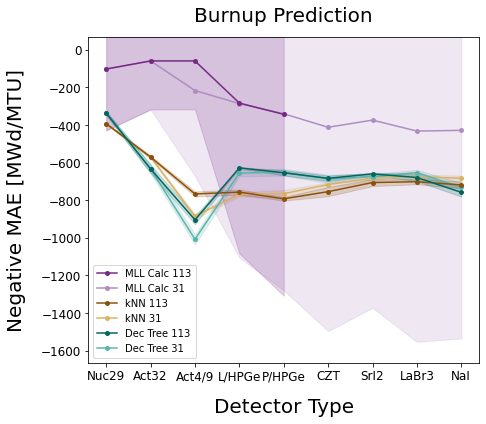

In [114]:
plot_curves('burnup', 'Burnup Prediction')

<Figure size 432x288 with 0 Axes>

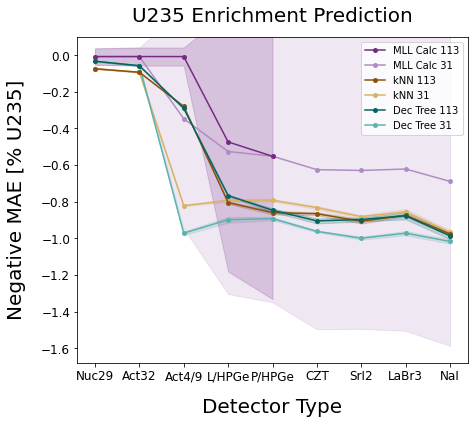

In [108]:
plot_curves('enrichment', 'U235 Enrichment Prediction')

<Figure size 432x288 with 0 Axes>

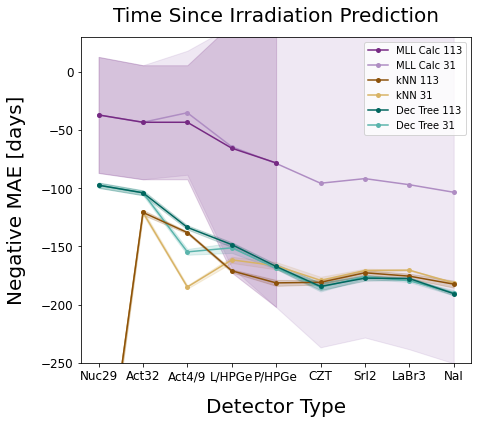

In [117]:
plot_curves('cooling', 'Time Since Irradiation Prediction')